In [1]:
import os, sys
# Add project root to Python path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [2]:
# GRADIENT CHECKING
import numpy as np
from lib.layers import Dense
from lib.activations import Tanh
from lib.losses import mse_loss, mse_loss_prime

def gradient_check(layer, input_data, target, epsilon=1e-4):
    """
    Verifies backpropagation by comparing Analytical Gradients (from code)
    vs Numerical Gradients (from finite difference formula).
    Formula: dL/dW approx [L(W + e) - L(W - e)] / (2 * e)
    """
    print(f"--- Gradient Check for {layer.__class__.__name__} Layer ---")
    
    # 1. Analytical Gradients 
    output = layer.forward(input_data)
    grad_output = mse_loss_prime(target, output)
    
    # We pass learning_rate=None because we only want to calculate gradients, not update
    layer.backward(grad_output, learning_rate=None) 
    
    # Get the gradients from the lib
    analytical_grad = layer.grad_weights.copy()
    
    # 2. Numerical Gradients (The "Brute Force" Check)
    numerical_grad = np.zeros_like(layer.weights)
    original_weights = layer.weights.copy()
    
    # Iterate over every single weight to perturb it
    it = np.nditer(layer.weights, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        
        # Calculate L(W + epsilon)
        layer.weights[idx] = original_weights[idx] + epsilon
        out_plus = layer.forward(input_data)
        loss_plus = mse_loss(target, out_plus)
        
        # Calculate L(W - epsilon)
        layer.weights[idx] = original_weights[idx] - epsilon
        out_minus = layer.forward(input_data)
        loss_minus = mse_loss(target, out_minus)
        
        # Central Difference Formula
        numerical_grad[idx] = (loss_plus - loss_minus) / (2 * epsilon)
        
        # Reset weight to original so we don't break the layer
        layer.weights[idx] = original_weights[idx]
        it.iternext()
        
    # 3. Compare Results
    numerator = np.linalg.norm(analytical_grad - numerical_grad)
    denominator = np.linalg.norm(analytical_grad) + np.linalg.norm(numerical_grad)
    
    # Avoid division by zero
    if denominator == 0:
        relative_error = 0
    else:
        relative_error = numerator / denominator

    print(f"   Analytical Gradient Norm: {np.linalg.norm(analytical_grad):.6f}")
    print(f"   Numerical Gradient Norm:  {np.linalg.norm(numerical_grad):.6f}")
    print(f"   Relative Error:           {relative_error:.2e}")
    
    if relative_error < 1e-5:
        print("   ✅ PASS: Backpropagation is correct.")
    else:
        print("   ❌ FAIL: Gradients diverge significantly.")
    print("-------------------------------------------------------")

# --- Run the Test ---
# Create random dummy data for testing
print("Generating random data for testing...")
test_input = np.random.randn(2).reshape(2,)   
test_target = np.random.randn(1).reshape(1,)

# Test a Dense Layer
test_layer = Dense(2, 1)
gradient_check(test_layer, test_input, test_target)

Generating random data for testing...
--- Gradient Check for Dense Layer ---
   Analytical Gradient Norm: 0.958773
   Numerical Gradient Norm:  0.958773
   Relative Error:           1.62e-13
   ✅ PASS: Backpropagation is correct.
-------------------------------------------------------


In [3]:
import numpy as np

# XOR dataset: 4 samples, 2 features, 1 output
x_train = np.array([
    [0, 0],
    [0, 1],
    [1, 0],
    [1, 1]
])

y_train = np.array([
    [0],
    [1],
    [1],
    [0]
])

print("XOR inputs:")
print(x_train)
print("XOR labels:")
print(y_train)

XOR inputs:
[[0 0]
 [0 1]
 [1 0]
 [1 1]]
XOR labels:
[[0]
 [1]
 [1]
 [0]]


In [4]:
from lib.network import Network
from lib.layers import Dense
from lib.activations import Tanh, Sigmoid
from lib.losses import mse_loss, mse_loss_prime
from lib.optimizer import SGD

# Create the network
net = Network()
net.add(Dense(2, 4))   # input 2 → hidden 4
net.add(Tanh())        # activation
net.add(Dense(4, 1))   # hidden 4 → output 1
net.add(Sigmoid())     # activation

# Set loss
net.use_loss(mse_loss, mse_loss_prime)

# Create optimizer
optimizer = SGD(learning_rate=0.1)

In [5]:
# Training the network
net.train(x_train, y_train, epochs=10000, learning_rate=0.1)

Epoch 1000/10000   error=0.002678
Epoch 2000/10000   error=0.001048
Epoch 3000/10000   error=0.000640
Epoch 4000/10000   error=0.000458
Epoch 5000/10000   error=0.000356
Epoch 6000/10000   error=0.000290
Epoch 7000/10000   error=0.000245
Epoch 8000/10000   error=0.000212
Epoch 9000/10000   error=0.000186
Epoch 10000/10000   error=0.000166


In [6]:
# Final predictions
print("XOR Predictions after training:")
for x, y_true in zip(x_train, y_train):
    pred = x
    for layer in net.layers:
        pred = layer.forward(pred)
    print(f"Input: {x}  Predicted: {pred[0]:.4f}  True: {y_true[0]}")

XOR Predictions after training:
Input: [0 0]  Predicted: 0.0051  True: 0
Input: [0 1]  Predicted: 0.9864  True: 1
Input: [1 0]  Predicted: 0.9864  True: 1
Input: [1 1]  Predicted: 0.0164  True: 0


Training for Loss Curve...
Training Complete.


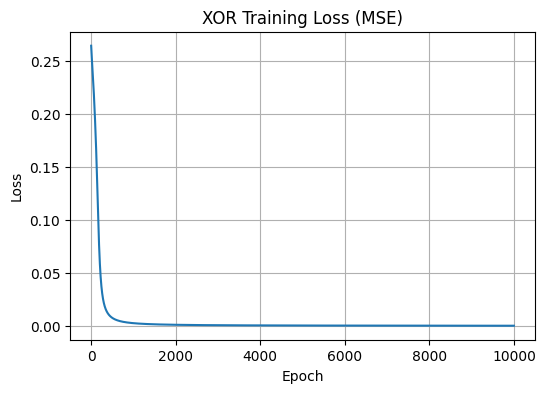

In [7]:
import matplotlib.pyplot as plt
from lib.optimizer import SGD 

# --- Reset Network for fresh training ---
net = Network()
net.add(Dense(2, 4))
net.add(Tanh())
net.add(Dense(4, 1))
net.add(Sigmoid())
net.use_loss(mse_loss, mse_loss_prime)
# -----------------------------------------------------------------------------------

# Setup for the manual loop
loss_history = []
epochs = 10000
learning_rate = 0.1  
optimizer = SGD(learning_rate=learning_rate)

print("Training for Loss Curve...")

for epoch in range(epochs):
    total_loss = 0
    for x, y in zip(x_train, y_train):
        # 1. Forward
        output = x
        for layer in net.layers:
            output = layer.forward(output)
            
        # 2. Loss
        total_loss += mse_loss(y, output)
        
        # 3. Backward (Calculate Gradients)
        grad = mse_loss_prime(y, output)
        for layer in reversed(net.layers):
            grad = layer.backward(grad, learning_rate=None) 
            
        # 4. Optimizer Step (Update Weights) 
        for layer in net.layers:
            optimizer.update(layer)
            
    loss_history.append(total_loss / 4)

print("Training Complete.")

# Plot
plt.figure(figsize=(6, 4))
plt.plot(loss_history)
plt.title("XOR Training Loss (MSE)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

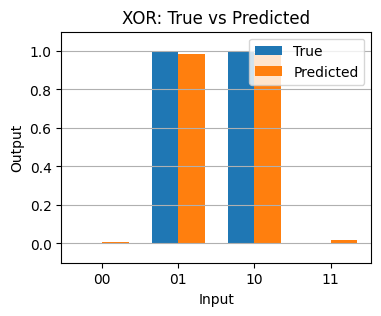

In [8]:
labels = ['00', '01', '10', '11']
true_vals = [0, 1, 1, 0]
pred_vals = [0.0059, 0.9851, 0.9876, 0.0156]  # use your actual preds

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(4, 3))
plt.bar(x - width/2, true_vals, width, label='True', color='tab:blue')
plt.bar(x + width/2, pred_vals, width, label='Predicted', color='tab:orange')
plt.xlabel("Input")
plt.ylabel("Output")
plt.title("XOR: True vs Predicted")
plt.xticks(x, labels)
plt.legend()
plt.ylim(-0.1, 1.1)
plt.grid(axis='y')
plt.show()

In [9]:
# Convert predictions to binary labels
predictions = []
for x in x_train:
    pred = x
    for layer in net.layers:
        pred = layer.forward(pred)
    label = 1 if pred[0] >= 0.5 else 0
    predictions.append(label)

# Accuracy
correct = np.sum(np.array(predictions) == y_train.flatten())
accuracy = correct / len(y_train) * 100

print("Predicted labels:", predictions)
print("True labels:     ", y_train.flatten().tolist())
print(f"XOR Accuracy: {accuracy:.1f}%")

Predicted labels: [0, 1, 1, 0]
True labels:      [0, 1, 1, 0]
XOR Accuracy: 100.0%


⚡ STARTING BENCHMARK: Custom Lib vs TensorFlow ⚡

1. Training Custom Model (10000 epochs)...
2. Training Keras Model (10000 epochs)...

--- 📊 BENCHMARK RESULTS ---
Metric               | My Library      | TensorFlow     
------------------------------------------------------------
Time Taken (s)       | 1.6675          | 360.6406       
Final Loss (MSE)     | 0.000166        | 0.000169       


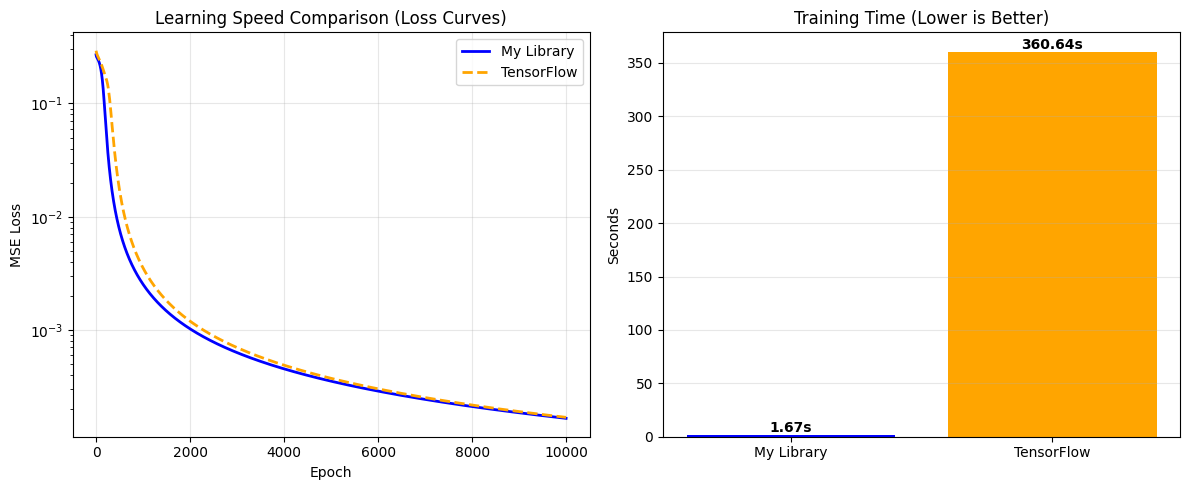

In [12]:
# Comparison (Our Lib vs TensorFlow)

import time
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from lib.network import Network
from lib.layers import Dense
from lib.activations import Tanh, Sigmoid
from lib.losses import mse_loss, mse_loss_prime
from lib.optimizer import SGD

print("⚡ STARTING BENCHMARK: Custom Lib vs TensorFlow ⚡")

# Constants for fair comparison
EPOCHS = 10000
LR = 0.1

# 1. CUSTOM LIBRARY TRAINING
print(f"\n1. Training Custom Model ({EPOCHS} epochs)...")
net = Network()
net.add(Dense(2, 4))
net.add(Tanh())
net.add(Dense(4, 1))
net.add(Sigmoid())
net.use_loss(mse_loss, mse_loss_prime)
custom_optimizer = SGD(learning_rate=LR)

custom_loss_history = []
start_time_custom = time.time()

for i in range(EPOCHS):
    epoch_loss = 0
    for j in range(len(x_train)):
        # Forward
        output = x_train[j]
        for layer in net.layers:
            output = layer.forward(output)
        epoch_loss += mse_loss(y_train[j], output)
        
        # Backward
        grad = mse_loss_prime(y_train[j], output)
        for layer in reversed(net.layers):
            grad = layer.backward(grad, learning_rate=None)
        
        # Update
        for layer in net.layers:
            custom_optimizer.update(layer)
            
    custom_loss_history.append(epoch_loss / len(x_train))

end_time_custom = time.time()
time_custom = end_time_custom - start_time_custom
final_loss_custom = custom_loss_history[-1]

# 2. TENSORFLOW/KERAS TRAINING
print(f"2. Training Keras Model ({EPOCHS} epochs)...")
model = keras.Sequential([
    keras.layers.Input(shape=(2,)),
    keras.layers.Dense(4, activation='tanh'),
    keras.layers.Dense(1, activation='sigmoid')
])
# We use SGD to match your optimizer exactly
keras_optimizer = keras.optimizers.SGD(learning_rate=LR)
model.compile(optimizer=keras_optimizer, loss='mse')

start_time_keras = time.time()
# batch_size=1 is crucial to match your "Update every sample" logic
history = model.fit(x_train, y_train, epochs=EPOCHS, batch_size=1, verbose=0)
end_time_keras = time.time()

time_keras = end_time_keras - start_time_keras
keras_loss_history = history.history['loss']
final_loss_keras = keras_loss_history[-1]

# 3. VISUALIZATION & REPORT
print("\n--- 📊 BENCHMARK RESULTS ---")
print(f"{'Metric':<20} | {'My Library':<15} | {'TensorFlow':<15}")
print("-" * 60)
print(f"{'Time Taken (s)':<20} | {time_custom:<15.4f} | {time_keras:<15.4f}")
print(f"{'Final Loss (MSE)':<20} | {final_loss_custom:<15.6f} | {final_loss_keras:<15.6f}")

# Plotting
plt.figure(figsize=(12, 5))

# Plot 1: Loss Curves Overlay
plt.subplot(1, 2, 1)
plt.plot(custom_loss_history, label='My Library', color='blue', linewidth=2)
plt.plot(keras_loss_history, label='TensorFlow', color='orange', linestyle='--', linewidth=2)
plt.title("Learning Speed Comparison (Loss Curves)")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log') # Log scale makes it easier to see small differences near 0

# Plot 2: Time Comparison Bar Chart
plt.subplot(1, 2, 2)
bars = plt.bar(['My Library', 'TensorFlow'], [time_custom, time_keras], color=['blue', 'orange'])
plt.title("Training Time (Lower is Better)")
plt.ylabel("Seconds")
plt.grid(axis='y', alpha=0.3)
# Add text on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f"{yval:.2f}s", ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()